# 확인사항

데이터 수집/전처리 ~ 정확도 산출의 과정을 로컬 환경과 Colab환경을 모두 활용하여 산출된 결과이므로 

코드가 정상적으로 작동하지 않을 수 있습니다.

* 원본 데이터 유무, 파일 경로 수정 등 사전확인 필요

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# csv파일 불러오기

In [ ]:
# #@title 로컬버전
# import os
# import numpy as np
# import pandas as pd

# def csv_loader(drive, type):        # 미리 정돈된 train, valid data set의 csv파일 불러오기
#     if type == 'train':
#         data = pd.read_csv(f"{drive}:\\python__\\Final\\train.csv")
#     else:
#         data = pd.read_csv(f"{drive}:\\python__\\Final\\valid.csv")
    
#     if drive == 'd':
#         data.name = data.name.str.replace("E","D")
    
#     del data['Unnamed: 0']
#     print("csv파일 로드 완료")
    
#     return data

In [ ]:
# train = csv_loader('e', 'train')
# valid = csv_loader('e', 'valid')

# train.head()
# valid.head()

In [ ]:
import os
import numpy as np
import pandas as pd

def csv_loader(type):        
# 미리 정돈된 train, valid data set의 csv파일 불러오기
# type = train or valid
    if type == 'train':
        data = pd.read_csv("/content/drive/MyDrive/train.csv", encoding = "utf-8")
    else:
        data = pd.read_csv("/content/drive/MyDrive/valid.csv", encoding = "utf-8")
    
    # if drive == 'd':
    #     data.name = data.name.str.replace("E","D")
    
    del data['Unnamed: 0']
    print("csv파일 로드 완료")
    
    return data

In [ ]:
train = csv_loader('train')
valid = csv_loader('valid')

csv파일 로드 완료
csv파일 로드 완료


In [ ]:
train.head()

,name,label,label_index
0,E:/다양한 형태의 한글 문자 OCR/Training/[원천]Training_필기체...,가,0
1,E:/다양한 형태의 한글 문자 OCR/Training/[원천]Training_필기체...,각,1
2,E:/다양한 형태의 한글 문자 OCR/Training/[원천]Training_필기체...,간,2
3,E:/다양한 형태의 한글 문자 OCR/Training/[원천]Training_필기체...,갇,3
4,E:/다양한 형태의 한글 문자 OCR/Training/[원천]Training_필기체...,갈,4


In [ ]:
valid.head()

,name,label,label_index
0,E:\다양한 형태의 한글 문자 OCR\Validation\[원천]validation...,가,0
1,E:\다양한 형태의 한글 문자 OCR\Validation\[원천]validation...,각,1
2,E:\다양한 형태의 한글 문자 OCR\Validation\[원천]validation...,간,2
3,E:\다양한 형태의 한글 문자 OCR\Validation\[원천]validation...,갇,3
4,E:\다양한 형태의 한글 문자 OCR\Validation\[원천]validation...,갈,4


# 전처리 class, def

### 로컬에서 실행

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch



class dataset():        
# 원본 데이터 -> 전처리 후 특정 폴더 저장 -> 분석 가능한 상태로 타입 변환을 위한 class 선언

    def data_storage(data, start, end):      
    # 원본데이터 -> size(50,50)으로 조정 -> 3차원의 RGB이미지를 1차원의 Gray scale로 변환 -> train, valid 폴더에 저장
    # data = train or valid / def csv_loader(type)
    # start/end = data에서 전처리 후 저장할 사진들의 시작/끝 인덱스 번호

        if len(data) > 100000:      # 두 세트의 데이터 양으로 train / valid판별
            folder_name = 'train'
        else:
            folder_name = 'valid'

        for i,j in zip(list(data.name)[start:end], range(start,end)):
            img = Image.open(i)
            img = img.resize((50,50))   # size(110,110) -> size(50,50)
            y = np.array(img)  # image -> numpy

            scaled_y0 = y[:,:,0]    
            # RGB -> Gray
            scaled_y0[(scaled_y0 >= 220)] = 255
            scaled_y0[(scaled_y0 < 220)] = 0
            # pixel값 서명하게 조절

            # 데이터 증강 필요할 시
            # scaled_y1 = y[:,:,1]
            # scaled_y2 = y[:,:,2]

            # scaled_y1[(scaled_y1 >= 220)] = 255
            # scaled_y2[(scaled_y2 >= 220)] = 255

            # scaled_y1[(scaled_y1 < 220)] = 0
            # scaled_y2[(scaled_y2 < 220)] = 0

            img_scaled_y = Image.fromarray(scaled_y0)
            # numpy -> image

            img_scaled_y.save(f'./{folder_name}_data/{j}.png','png')
            # 특정폴더에 번호순으로 저장
            
            if j % 3000 == 0:
                print(f"{j}개째 완료")
            
        print(f"{end}개 완료")

    
    def data_ready(drive, data):        
        # 전처리 후 특정 폴더에 저장된 이미지들 -> tensor형태로 전환
        # drive = 로컬에서 특정 폴더의 위치 / c, d, e ...
        # data = train or valid / def csv_loader(type) 
        drive = drive.upper()
        
        if len(data) > 100000:
            folder_name = 'train'
        else:
            folder_name = 'valid'
        
        img_path_list = []
        for i in range(len(os.listdir(f"{drive}:\\python__\\Final\\{folder_name}_data\\"))):    # 특정폴더 내 모든 데이터 개수
            img_name = f"{i}.png"   # 이미지들 이름
            img_path = os.path.join(f"{drive}:\\python__\\Final\\{folder_name}_data\\", img_name)   # 경로+이미지 이름
            img_path_list.append(img_path)
        # img_path_list

        # 데이터셋 텐서형태로 stack
        out_list = []
        for i in range(len(img_path_list)):
            img = Image.open(img_path_list[i])
            y = np.array(img)  # 이미지 -> 넘파이
            x = torch.from_numpy(y) # 넘파이 -> 텐서

            out_list.append(x)  # 리스트 내 텐서들 삽입
            if i % 10000 == 0:
                print(f"{i}까지 진행됨.")
            
        train_data = torch.stack(out_list, dim = 0) # 전체 텐서 stack

        print("데이터 구축 완료")
        print(train_data.size())
        
        return train_data
        
    
    def save_data_npy(data, label):
    # stacked tensor를 .npy로 외부에 저장
    # data = def data_ready(drive, data) / train or valid
    # label = def label_loader(data)
        if len(data) > 100000:
            folder_name = 'train'
        else:
            folder_name = 'valid'
            
        # 텐서를 외부파일로저장
        a = data
        a_1 = label
        
        # 텐서 -> 넘파이
        a_np = a.numpy()
        a_np_1 = a_1.numpy()
        
        # 넘파이 -> 외부파일
        np.save(f'{folder_name}_data', a_np)
        np.save(f'{folder_name}_target', a_np_1)
        
        # 외부파일 -> 넘파이
        np_load = np.load(f'{folder_name}_data.npy')
        np_load_1 = np.load(f'{folder_name}_target.npy')
        
        # 넘파이 -> 텐서
        result = torch.from_numpy(np_load)
        result_1 = torch.from_numpy(np_load_1)
        
        return result, result_1
    
    
    def load_data_npy(data, label):
        # 외부파일을 텐서로 불러오기
        # data = def data_ready(drive, data) / train or valid
        # label = def label_loader(data)
        np_load = np.load(data)
        np_load_1 = np.load(label)
        
        result = torch.from_numpy(np_load)
        result_1 = torch.from_numpy(np_load_1)
        
        return result, result_1

    
    def label_loader(data):
    # label들만 따로 불러오기
        if len(data) > 100000:
            type_data = train_data
            type_target = train_target
        else:
            type_data = valid_data
            type_target = valid_target
            
        target = data.label_index[:len(type_data)]
        type_target = torch.from_numpy(target.values)
        
        print("label 구축 완료")
        print(type_target.size())
        
        return type_target
        
        
    def plot(type, index):
    # 예시 그림그려보기
        if type == 'valid':
            type_data = valid_data
        else:
            type_data = train_data
            
        x = type_data[index]
        img = (np.array(x.detach().cpu(), dtype='float'))

        plt.imshow(img, cmap='gray')
        plt.show()

# 분석 실행


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


np_load = np.load('/content/drive/MyDrive/train_data.npy')
np_load_1 = np.load('/content/drive/MyDrive/train_target.npy')

train_data = torch.from_numpy(np_load)
train_target = torch.from_numpy(np_load_1)

np_load_v = np.load('/content/drive/MyDrive/valid_data.npy')
np_load_v_1 = np.load('/content/drive/MyDrive/valid_target.npy')

valid_data = torch.from_numpy(np_load_v)
valid_target = torch.from_numpy(np_load_v_1)

## DNN

In [ ]:
x = train_data.float() / 255.
y = train_target

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

In [ ]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) - train_cnt)
test_cnt = int(valid_data.size(0))
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(valid_data.float() / 255.).view(test_cnt, -1)]
y += [valid_target]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 215981 / Valid 53996 / Test 33114 samples.
torch.Size([215981, 50, 50]) torch.Size([215981])
torch.Size([53996, 50, 50]) torch.Size([53996])
torch.Size([33114, 2500]) torch.Size([33114])


## CNN

In [ ]:

x = train_data.float() / 255.
y = train_target

# x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([269977, 50, 50]) torch.Size([269977])
input_size: 50, output_size: 2352


In [ ]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) - train_cnt)
test_cnt = int(valid_data.size(0))
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(valid_data.float() / 255.)]
y += [valid_target]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 215981 / Valid 53996 / Test 33114 samples.
torch.Size([215981, 50, 50]) torch.Size([215981])
torch.Size([53996, 50, 50]) torch.Size([53996])
torch.Size([33114, 50, 50]) torch.Size([33114])


## RNN(LSTM)

In [ ]:
x = train_data.float() / 255.
y = train_target

# x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([269977, 50, 50]) torch.Size([269977])
input_size: 50, output_size: 2352


In [ ]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) - train_cnt)
test_cnt = int(valid_data.size(0))
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(valid_data.float() / 255.)]
y += [valid_target]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 215981 / Valid 53996 / Test 33114 samples.
torch.Size([215981, 50, 50]) torch.Size([215981])
torch.Size([53996, 50, 50]) torch.Size([53996])
torch.Size([33114, 50, 50]) torch.Size([33114])


# model

## DNN (Regulalization)

In [ ]:
class Block(nn.Module):
    
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__()
        
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )
        
    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.block(x)
        # |y| = (batch_size, output_size)
        
        return y
        
class MyModel(nn.Module):
    
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):
        
        super().__init__()
        
        self.layers = nn.Sequential(
            Block(input_size, 1800, use_batch_norm, dropout_p),
            Block(1800, 1500, use_batch_norm, dropout_p),
            Block(1500, 1024, use_batch_norm, dropout_p),
            Block(1024, 512, use_batch_norm, dropout_p),
            Block(512, 256, use_batch_norm, dropout_p),
            Block(256, 128, use_batch_norm, dropout_p),
            Block(128, 256, use_batch_norm, dropout_p),
            Block(256, 512, use_batch_norm, dropout_p),
            Block(512, 1024, use_batch_norm, dropout_p),
            Block(1024, 2048, use_batch_norm, dropout_p),
            nn.Linear(2048, output_size),
            nn.LogSoftmax(dim=-1),
        )
        
    def forward(self, x):
        # |x| = (batch_size, input_size)        
        y = self.layers(x)
        # |y| = (batch_size, output_size)
        
        return y

In [ ]:
model = MyModel(input_size,
                output_size,
                use_batch_norm=True)

model

## CNN

In [ ]:
import torch
import torch.nn as nn


class ConvolutionBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels

        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, (3, 3), stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        # |x| = (batch_size, in_channels, h, w)

        y = self.layers(x)
        # |y| = (batch_size, out_channels, h, w)

        return y


class ConvolutionalClassifier(nn.Module):

    def __init__(self, output_size):
        self.output_size = output_size

        super().__init__()

        self.blocks = nn.Sequential( # |x| = (n, 1, 50, 50)
            ConvolutionBlock(1, 32), # (n, 32, 24, 24)
            ConvolutionBlock(32, 64), # (n, 64, 12, 12)
            ConvolutionBlock(64, 128), # (n, 128, 6, 6)
            ConvolutionBlock(128, 256), # (n, 256, 3, 3)
            ConvolutionBlock(256, 512), # (n, 512, 2, 2)
            ConvolutionBlock(512, 1024), # (n, 1024, 1, 1)
        )
        self.layers = nn.Sequential(
            nn.Linear(1024, 1500),
            nn.ReLU(),
            nn.BatchNorm1d(1500),
            nn.Linear(1500, output_size),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, x):
        assert x.dim() > 2

        if x.dim() == 3:
            # |x| = (batch_size, h, w)
            x = x.view(-1, 1, x.size(-2), x.size(-1))
        # |x| = (batch_size, 1, h, w)

        z = self.blocks(x)
        # |z| = (batch_size, 512, 1, 1)

        y = self.layers(z.squeeze())
        # |y| = (batch_size, output_size)

        return y


In [ ]:
model = ConvolutionalClassifier(2352)

## RNN(LSTM)

In [ ]:
class SequenceClassifier(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        n_layers=4,
        dropout_p=.2,
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p,
            bidirectional=True,
        )
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size * 2),
            nn.Linear(hidden_size * 2, output_size),
            nn.LogSoftmax(dim=-1),
        )
    def forward(self, x):
        # |x| = (batch_size, h, w)
        z, _ = self.rnn(x)
        # |z| = (batch_size, h, hidden_size * 2)
        z = z[:, -1]
        # |z| = (batch_size, hidden_size * 2)
        y = self.layers(z)
        # |y| = (batch_size, output_size)
        return y


In [ ]:
model = SequenceClassifier(
            input_size = 50,
            hidden_size = 64,
            output_size = 2352,
            n_layers = 8,
            dropout_p = 0.2,
        )

# 공통 (손실함수, 최적화, cuda, H_P, train)

In [ ]:
crit = nn.NLLLoss()

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [ ]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [ ]:
device

device(type='cuda')

In [ ]:
n_epochs = 100
batch_size = 512
print_interval = 10

In [ ]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [ ]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    model.eval()
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

In [ ]:
model.load_state_dict(best_model)

<All keys matched successfully>

# loss
###  ---- RNN / hs : 64 / layers : 8 / bs : 512

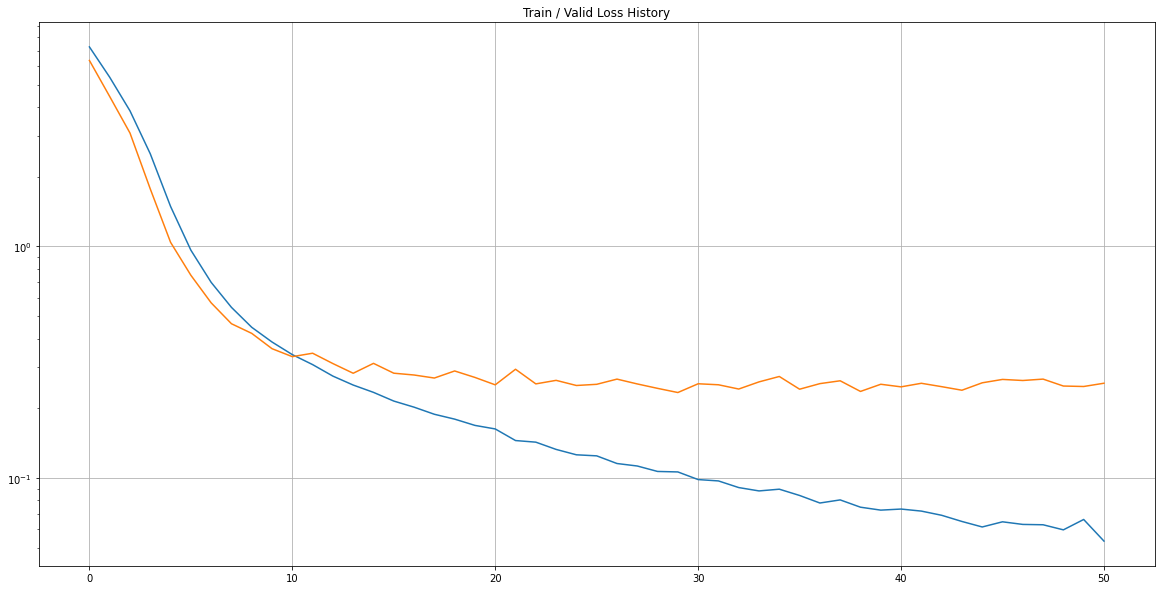

In [ ]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [ ]:
# model.load_state_dict(best_model)

model.eval()
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4e" % test_loss)

Validation loss: 2.3874e-01


# Accuracy

### RNN / hs : 64 / layers : 4 / bs : 512

In [ ]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9376


### RNN / hs : 128 / layers : 8 / bs : 512

In [ ]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9452


### RNN / hs : 64 / layers : 8 / bs : 512

In [ ]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9482


# model.pth

In [ ]:
torch.save(best_model, 'rnn_model_hs64_layers8.pth')
device = torch.device("cuda")

In [ ]:
model = SequenceClassifier(
            input_size = 50,
            hidden_size = 64,
            output_size = 2352,
            n_layers = 8,
            dropout_p = 0.2,
        )

In [ ]:
model.load_state_dict(torch.load('rnn_model_hs64_layers8.pth'))
model.to(device)

SequenceClassifier(
  (rnn): LSTM(50, 64, num_layers=8, batch_first=True, dropout=0.2, bidirectional=True)
  (layers): Sequential(
    (0): ReLU()
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=2352, bias=True)
    (3): LogSoftmax(dim=-1)
  )
)